In [49]:
import os

import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import Pool, CatBoostClassifier

import isodate
import datetime

import re

from gensim.models import FastText
import gensim

In [50]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

In [51]:
scopes = ["https://www.googleapis.com/auth/youtube.readonly"]
#           "https://www.googleapis.com/auth/youtubepartner-channel-audit",
#           "https://www.googleapis.com/auth/youtubepartner"]

os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

api_service_name = "youtube"
api_version = "v3"
client_secrets_file = "my_client_desktop.json"
channel_id = 'UCQIRSud94PUpBjMIjM_wgiA'
# channel_id = 'UC0MpTTqWtX6xUFR8Ee4Vd6A' # Айсена Андреева (Канал Алексея)
# channel_id = 'UC9wpw9wWC-8kCs4ho7Uiptw' # Id Айсена Антонова

In [ ]:
flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(
        client_secrets_file, scopes)
credentials = flow.run_console()
youtube = googleapiclient.discovery.build(
        api_service_name, api_version, credentials=credentials)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=543654904839-lltmk49hvj2bb11eofgrhemrg2djtv89.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.readonly&state=RLgTHwLjuFyfCoJAciWyYDqwLiHL5a&prompt=consent&access_type=offline


## Функция для получения статистики о канале

In [5]:
def get_channel_stats(youtube, channel_id):
    
    request = youtube.channels().list(
            part='snippet,contentDetails,statistics',
            id=channel_id)
    response = request.execute()
    
    data = dict(Channel_name = response['items'][0]['snippet']['title'],
                Subscribers = response['items'][0]['statistics']['subscriberCount'],
                Description = response['items'][0]['snippet']['description'],
                Views = response['items'][0]['statistics']['viewCount'],
                Total_videos = response['items'][0]['statistics']['videoCount'])
    
    return data

In [6]:
channel_statistics = get_channel_stats(youtube, channel_id)
channel_data = pd.DataFrame(channel_statistics, index=[0])
# channel_data

## Функция для получения статистики о понравившихся видео (Алгоритмы YouTube)

In [7]:
def get_my_liked_videos_stats(youtube):
    all_data = []
    nextPageToken = None
    for i in range(1, 40):  # 40 Потому что больше 2000 данных будет избыточно.
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics,player",
            myRating="like",
            maxResults=50,
            pageToken=nextPageToken
        )
        
        response = request.execute()
        
        for i in range(len(response['items'])):
            data = dict(PublishedAt = response['items'][i]['snippet']['publishedAt'],
                        ChannelId = response['items'][i]['snippet']['channelId'],
                        Title = response['items'][i]['snippet']['title'],
                        Tags = response['items'][i]['snippet'].get('tags'),
                        Kind = response['items'][i]['kind'],
                        Description = response['items'][i]['snippet']['description'],
                        ChannelTitle = response['items'][i]['snippet']['channelTitle'],
                        Id_video_category = response['items'][i]['snippet']['categoryId'],
                        liveBroadcastContent = response['items'][i]['snippet']['liveBroadcastContent'],
                        Duration = response['items'][i]['contentDetails']['duration'],
                        ViewCount = response['items'][i]['statistics'].get('viewCount'),
                        LikeCount = response['items'][i]['statistics'].get('likeCount'),
                        )
            all_data.append(data)
        
        nextPageToken = response.get('nextPageToken')
        if not nextPageToken: 
            break
    
    return all_data

In [8]:
my_liked_videos_stats = get_my_liked_videos_stats(youtube)
my_liked_videos_data = pd.DataFrame(my_liked_videos_stats)
my_liked_videos_data

,PublishedAt,ChannelId,Title,Tags,Kind,...,Id_video_category,liveBroadcastContent,Duration,ViewCount,LikeCount
0,2023-12-09T15:39:26Z,UC8Nr8-MUDIgSGYbVNqRKpAg,Сестра Шелдона стала копом #шелдон #моментизфи...,None,youtube#video,...,22,none,PT23S,445389,24008
1,2023-12-14T14:31:40Z,UCg5-gDdzP3GVyVtWHZM0BKw,Может выбрать любую способность 🤯 #аниме #anim...,"[аниме, аниме все серии, аниме все серии подря...",youtube#video,...,1,none,PT55S,94587,6928
2,2023-12-21T16:02:08Z,UCtn7MV_qFYDZIihjJp4AJuw,В колледж после 9 класса школы вместо вуза - ч...,"[поступление, институт, ЕГЭ, экзамены, образов...",youtube#video,...,27,none,PT57S,36900,3091
3,2023-12-21T12:00:18Z,UCYV8EwdZIIBagEZD11QtPwQ,"Чем является Дыра из ""Рика и Морти""?","[рик и морти, рик и морти 7 сезон, рик и морти...",youtube#video,...,1,none,PT8M51S,352728,23369
4,2023-12-14T12:58:38Z,UCMHkIHfUDCgYSheCKSiAntg,Президент просто шикарно ответил «двойнику»😂👍🏻...,None,youtube#video,...,22,none,PT47S,4317805,153035
...,...,...,...,...,...,...,...,...,...,...,...
984,2022-07-12T15:55:39Z,UCIn6hza5Ai119FJnLMJzECQ,МЁРТВЫЙ РАЗУМ ПРОГРАММИСТА | ALEK OS,"[Мёртвый разум программиста, программирование,...",youtube#video,...,27,none,PT15M20S,95517,7305
985,2023-06-01T14:59:39Z,UCJ8AJ0qd2-gk90OujUETzCg,"Донос, долги и жизнь в Тайланде | В офисе Фил ...","[фил ранжин, it, программист, релокация, релок...",youtube#video,...,22,none,PT1H11M50S,17189,695
986,2023-05-25T14:42:19Z,UCSfs2OeyOX0r5ZucDho8voQ,КОРЕЯНКА КАЙФУЕТ ОТ РУССКОГО РАЙОНА В СЕУЛЕ/ТУ...,None,youtube#video,...,22,none,PT56S,987753,50899
987,2023-05-31T12:04:17Z,UCuF8ghQWaa7K-28llm-K3Zg,АНИМЕ ЛЕТО 2023,"[АниЛибрия, AniLibria, анонс сезона, аниме сез...",youtube#video,...,22,none,PT26M37S,574009,27563


## Функция для получения RU категорий на YouTube

In [9]:
def get_video_categories(youtube):
    all_data = []
    request = youtube.videoCategories().list(
        part="snippet",
        hl="RU",
        regionCode="RU"
    )
    response = request.execute()

    for i in range(len(response['items'])):
        data = dict(Id_video_category = response['items'][i]['id'],
                    Category = response['items'][i]['snippet']['title'],
                    Assignable = response['items'][i]['snippet']['assignable'], # Имеет ли возможность иметь несколько категорий
                    )
        all_data.append(data)
    return all_data

In [10]:
video_categories = get_video_categories(youtube)
video_categories_data = pd.DataFrame(video_categories)
# video_categories_data

## Функция для получения статистики о подписках

In [11]:
def get_subscriptions_stats(youtube, channel_id):
    all_data = []
    nextPageToken = None
    for i in range(1, 20):  # 20 Потому что больше 1000 данных будет избыточно.
        request = youtube.subscriptions().list(
            part="snippet,contentDetails,subscriberSnippet,id",
            channelId=channel_id,
            maxResults=50,
            pageToken=nextPageToken
        )
        
        response = request.execute()
        
        for i in range(len(response['items'])):
            data = dict(Channel_name = response['items'][i]['snippet']['title'],
                        Description = response['items'][i]['snippet']['description'],
                        Subscription_time = response['items'][i]['snippet']['publishedAt'],
                        ChannelId = response['items'][i]['snippet']['resourceId']['channelId'])
            all_data.append(data)
        
        nextPageToken = response.get('nextPageToken')
        if not nextPageToken: 
            break
    
    return all_data

In [12]:
subscriptions_stats = get_subscriptions_stats(youtube, channel_id)
subscriptions_stats_data = pd.DataFrame(subscriptions_stats)
subscriptions_stats_data

,Channel_name,Description,Subscription_time,ChannelId
0,Эрик Шоков,"🔥 Bro, gotta practice on CYBERSHOKE!\n\nHey, I...",2021-05-19T18:23:26.770607Z,UC6ZQezbR7LwGgxTB-xt0xAw
1,Soderling,"Привет, ребята, добро пожаловать на мой канал!...",2021-10-09T18:23:47.762893Z,UCYV8EwdZIIBagEZD11QtPwQ
2,PRO Hi-Tech,Мы не запрашиваем товары на тест! Если вам пре...,2021-02-07T08:42:13.213671Z,UC6uFoHcr_EEK6DgCS-LeTNA
3,JYP Entertainment,JYPnation Official YouTube\n\nLEADER IN ENTERT...,2021-05-14T05:44:14.231661Z,UCaO6TYtlC8U5ttz62hTrZgg
4,이렐킹 IRELKING,챌린저 이렐리아 장인 이렐킹 유튜브 채널입니다.,2022-04-18T14:56:32.891141Z,UCi-0jmyw3x6efk090BAVfxA
...,...,...,...,...
190,SHORTS [Короткометражки] DeeAFilm,Только лучший перевод и только качественная оз...,2020-02-13T19:05:28.490179Z,UCa3wYfG33pxNrtKkZ61L2xA
191,Sergej Kuts,,2020-01-23T13:46:07.054608Z,UCi3lxprPEKGjpmzzN90sceA
192,itpedia - Смешные моменты,,2019-12-29T20:02:46.341311Z,UCrjz_vuAPKNFrVbSfAEzDTw
193,Valery Volkov,Видеоуроки по математике.\nTelegram: https://t...,2019-10-06T08:07:36.46237Z,UCLDpIKDTFBSwIYtAG0Wpibg


## Функция для получения статистики об активностях

In [13]:
def get_activities_stats(youtube, channel_id):
    all_data = []
    nextPageToken = None
    for i in range(1, 20):  # 20 Потому что больше 1000 данных будет избыточно.
        request = youtube.activities().list(
            part="snippet,contentDetails",
            channelId=channel_id,
            maxResults=50,
            pageToken=nextPageToken
        )
        
        response = request.execute()
        
        for i in range(len(response['items'])):
            data = dict(Date = response['items'][i]['snippet']['publishedAt'],
                    Channel_name = response['items'][i]['snippet']['channelTitle'],
                    type = response['items'][i]['snippet']['type'])
            all_data.append(data)
        
        nextPageToken = response.get('nextPageToken')
        if not nextPageToken: 
            break
    
    return all_data

In [14]:
activities_statistics = get_activities_stats(youtube, channel_id)
activities_data = pd.DataFrame(activities_statistics)
activities_data

,Date,Channel_name,type
0,2023-12-17T00:56:27+00:00,Дата Бой,subscription
1,2023-12-11T11:47:40+00:00,IT GIRL,subscription
2,2023-12-10T07:46:59+00:00,Thu Vu data analytics,subscription
3,2023-12-02T09:29:09+00:00,Anton Glad,subscription
4,2023-11-29T06:43:21+00:00,Data Science Guy,subscription
...,...,...,...
104,2021-08-09T04:28:46+00:00,ODS AI Global,subscription
105,2021-08-08T02:36:02+00:00,НИКОЛАЙ ПО-КОРЕЙСКИ,subscription
106,2021-08-05T10:43:30+00:00,Тимофей Хирьянов,subscription
107,2021-08-04T03:59:19+00:00,ODS AI Ru,subscription


## Аналитика данных

Читаем файл video_categories_weights с весами.

In [15]:
video_categories_weights = pd.read_excel('video_categories.xlsx')
video_categories_weights

,Id_video_category,Category,Weight
0,27,Образование,1.00
1,28,Наука и техника,0.75
2,26,Хобби и стиль,0.75
3,17,Спорт,0.70
4,2,Транспорт,0.70
...,...,...,...
26,44,Трейлеры,0.08
27,42,Короткометражные,0.08
28,34,Юмор,0.05
29,24,Развлечения,0.05


Приведение типов с object на int для того, чтобы можно было посмотреть данные и обучить модель

In [16]:
video_categories_weights['Id_video_category'] = video_categories_weights['Id_video_category'].astype(int)
my_liked_videos_data['Id_video_category'] = my_liked_videos_data['Id_video_category'].astype(int)
df = my_liked_videos_data.merge(video_categories_weights, left_on='Id_video_category', right_on="Id_video_category")

## Фильтр данных и предобработка реальных данных

Сейчас мы будем фильтровать видео длиной менее 1 минуты и более 200 минут. 

Также мы уберем цифры и оставим только символы от а до я и от a до z. 

Также весь текст мы сделаеи нижнем регистре. Еще убираем пустые строки и между словами делаем чтобы был 1 пробел.

In [17]:
df

,PublishedAt,ChannelId,Title,Tags,Kind,...,Duration,ViewCount,LikeCount,Category,Weight
0,2023-12-09T15:39:26Z,UC8Nr8-MUDIgSGYbVNqRKpAg,Сестра Шелдона стала копом #шелдон #моментизфи...,None,youtube#video,...,PT23S,445389,24008,Люди и блоги,0.10
1,2023-12-14T12:58:38Z,UCMHkIHfUDCgYSheCKSiAntg,Президент просто шикарно ответил «двойнику»😂👍🏻...,None,youtube#video,...,PT47S,4317805,153035,Люди и блоги,0.10
2,2023-11-20T18:26:26Z,UCYIZq5bdY3XKKguiu0Xa8Sg,Он слишком силён для одноклассников 🤯🔥 | КОД: ...,None,youtube#video,...,PT58S,1009774,None,Люди и блоги,0.10
3,2023-11-07T19:05:43Z,UC9zAtI0JZO9uOWTR-PF0x4w,СУДЕБНЫЙ ПРОЦЕСС #влог #влоги #учеба #обзоры #...,"[motivational, motivational speech, motivation...",youtube#video,...,PT1M,538859,47948,Люди и блоги,0.10
4,2023-12-10T05:11:16Z,UCYIZq5bdY3XKKguiu0Xa8Sg,"Этот парень обладает невероятной силой, но он ...",None,youtube#video,...,PT59S,887541,None,Люди и блоги,0.10
...,...,...,...,...,...,...,...,...,...,...,...
959,2023-09-11T08:38:28Z,UC0fhvXUsHspR6LiQnJzuCRg,Как сэкономила 30 000 руб !,None,youtube#video,...,PT13S,10035,112,Хобби и стиль,0.75
960,2019-08-27T09:51:06Z,UClcioJjtFDB0shnRhxsUjog,Бассейн (piscine) в бесплатной школе программи...,"[программист, программирование, программирован...",youtube#video,...,PT13M42S,5407,109,Хобби и стиль,0.75
961,2022-10-30T20:42:22Z,UCOOFNI2j4sLIa2rbhbHpBCg,Греф об управлении массами.,None,youtube#video,...,PT1M56S,22118,392,Спорт,0.70
962,2023-06-23T11:00:48Z,UCtctOXlHYeQyuXSgW861nMA,챌린지 하다가 목이 꺾였다고⁉️😱 Waist Flexibility Challenge,None,youtube#video,...,PT45S,61104670,2613676,Спорт,0.70


In [18]:
# Мы здесь проходимся по циклу 5 раз. можно 1 раз.

df['total_seconds'] = df['Duration'].apply(isodate.parse_duration)

interval_min = np.timedelta64(1, 'm')
interval_max = np.timedelta64(200, 'm')
filtered_dataset = df[(df['total_seconds'] > interval_min) & (df['total_seconds'] < interval_max)]

filtered_dataset.loc[:, 'Title'] = filtered_dataset.loc[:, 'Title'].str.lower()
filtered_dataset.loc[:, 'Title'] = filtered_dataset.loc[:, 'Title'].str.replace('\d+', '', regex=True)
filtered_dataset.loc[:, 'Title'] = filtered_dataset.loc[:, 'Title'].str.replace('[^а-яА-Яa-zA-Z\s]', '', regex=True)

In [19]:
filtered_dataset

,PublishedAt,ChannelId,Title,Tags,Kind,...,ViewCount,LikeCount,Category,Weight,total_seconds
9,2020-08-18T08:38:25Z,UC4zWkr8wesB2-qliEayfMxw,многоклассовая классификация текста на python,"[python, NLP, NLTK, sklearn, анализ текста, кл...",youtube#video,...,8172,230,Люди и блоги,0.10,0 days 00:53:41
10,2023-10-01T18:59:03Z,UC3u7hWQJojXuh5JY1jLUNPQ,senior разработчик в лет,[Sгур],youtube#video,...,31445,1638,Люди и блоги,0.10,0 days 00:40:55
13,2023-09-20T14:28:09Z,UC5CzMNn6Qhm8Ms1W1UUlQYQ,привычки моего мужаяпонца перфекционист,None,youtube#video,...,853283,67755,Люди и блоги,0.10,0 days 00:01:01
15,2022-12-07T08:16:12Z,UCuq6VZoQMNhNy6JIhJh-zWQ,как мы выиграли хакатон вебдизайнеров itland,None,youtube#video,...,935,69,Люди и блоги,0.10,0 days 00:23:08
16,2023-12-11T05:00:31Z,UC7vgoI5o3Eik81K6nwd1_eQ,негибкий мозг программиста старше,"[программирование, программист, python, как ст...",youtube#video,...,12559,764,Люди и блоги,0.10,0 days 00:06:50
...,...,...,...,...,...,...,...,...,...,...,...
957,2023-04-28T15:54:52Z,UC47mAy6Boq9z4lELLqD-hPg,почему население китая уменьшается,None,youtube#video,...,280476,13429,Хобби и стиль,0.75,0 days 00:08:30
958,2023-05-05T15:00:50Z,UCMdElTwiU4JrDUkuI_eqPJg,van valorant windows error fixed this build...,"[fix van 9003 valorant windows 11, how to fix ...",youtube#video,...,1304239,11410,Хобби и стиль,0.75,0 days 00:06:58
960,2019-08-27T09:51:06Z,UClcioJjtFDB0shnRhxsUjog,бассейн piscine в бесплатной школе программиро...,"[программист, программирование, программирован...",youtube#video,...,5407,109,Хобби и стиль,0.75,0 days 00:13:42
961,2022-10-30T20:42:22Z,UCOOFNI2j4sLIa2rbhbHpBCg,греф об управлении массами,None,youtube#video,...,22118,392,Спорт,0.70,0 days 00:01:56


## Инфографика по категориям

In [20]:
df_c = filtered_dataset[['Category', 'LikeCount']].groupby(['Category']).count().sort_values(by='LikeCount', ascending=False).reset_index()
df_c = df_c.head(10)

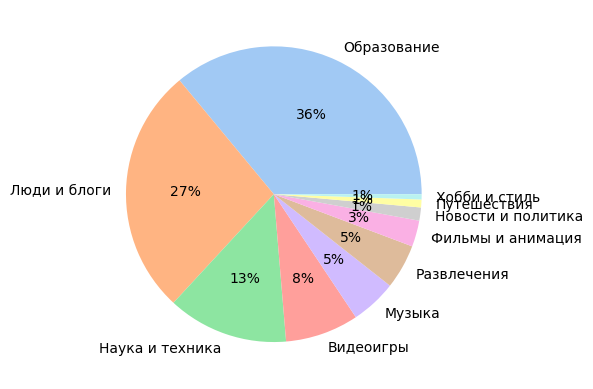

In [21]:
colors = sns.color_palette('pastel')

plt.pie(df_c['LikeCount'], labels = df_c['Category'], colors = colors, autopct='%.0f%%')
plt.show()

In [22]:
result = df_c

In [23]:
df_c

,Category,LikeCount
0,Образование,251
1,Люди и блоги,189
2,Наука и техника,92
3,Видеоигры,56
4,Музыка,35
5,Развлечения,34
6,Фильмы и анимация,20
7,Новости и политика,10
8,Путешествия,6
9,Хобби и стиль,4


## Статистика по кол-ву тэгов и инфографика по тэгам

In [24]:
res = [item for sublist in filtered_dataset['Tags'] if sublist is not None for item in sublist]

Здесь идет предобработка данных.

Мы уберем цифры и оставим только символы от а до я и от a до z. 

Также весь текст мы сделаеи нижнем регистре. Еще убираем пустые строки и между словами делаем чтобы был 1 пробел.

In [25]:
res = [x.lower() for x in res]
res = [re.sub('\d+', '', x) for x in res]
res = [re.sub('[^а-яА-Яa-zA-Z\s]', '', x) for x in res]
res = [x.strip() for x in res]
res = [x for x in res if x.strip() != '']

Результат работы. (Показываю только 10)

In [29]:
res[:10]

['python',
 'nlp',
 'nltk',
 'sklearn',
 'анализ текста',
 'классификация',
 'sгур',
 'программирование',
 'программист',
 'python']

Здесь мы считаем сколько всего каких тэгов. Например как много таких или иных тэгов

In [30]:
tag_counts = {}
for tag in res:
    tag_counts[tag] = tag_counts.get(tag, 0) + 1
    
sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)
top_tags = sorted_tags[:50]

Инфографика тэгов

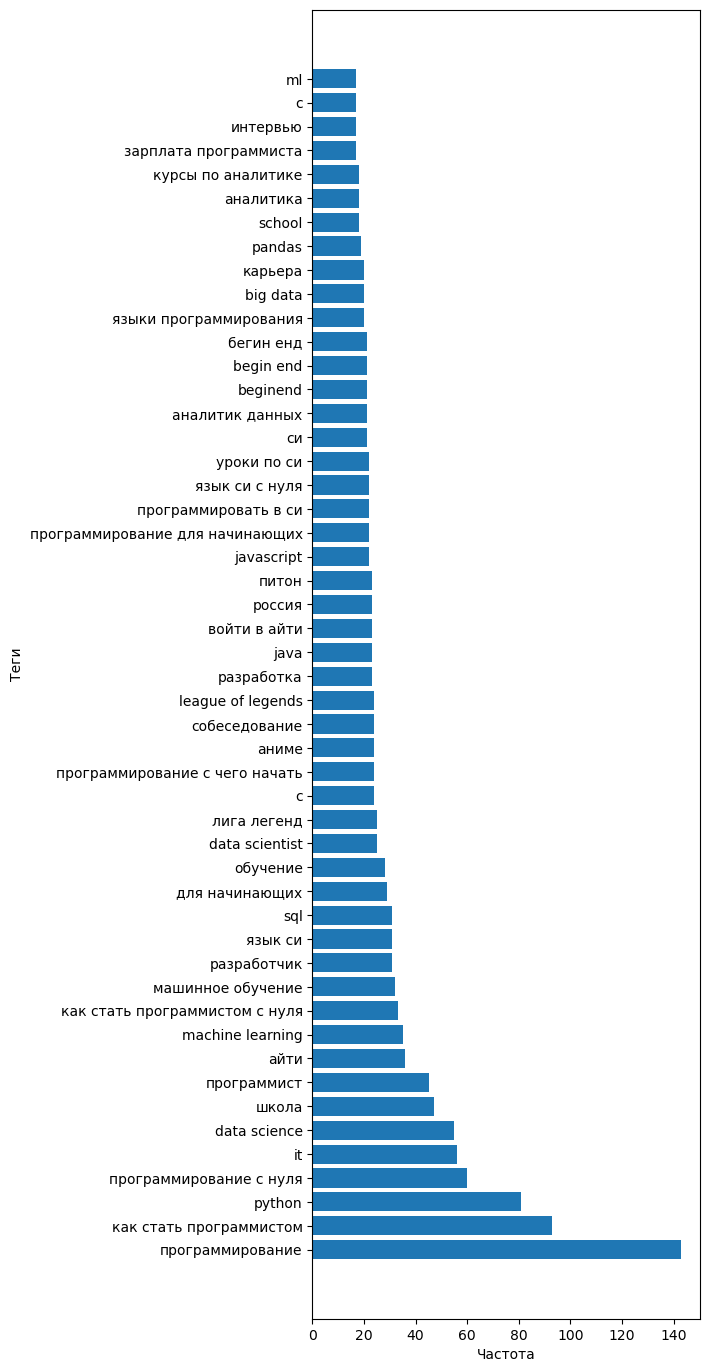

In [31]:
tags, freq = zip(*top_tags)
fig, ax = plt.subplots()

ax.barh(tags, freq)
ax.set_ylabel('Теги')
ax.set_xlabel('Частота')
fig.set_size_inches(5, 17)

plt.show()

In [32]:
result2 = top_tags

## Обучение модели по тэгам

Читаем наш датасет

In [33]:
tag_dataset = pd.read_excel('dataset.xlsx')

Предобработка данных. Снова убираем цифры, делаем нижний регистр, пустые строки убираем и тд.

Убираем кол-во профессий которое меньше 5.

In [34]:
tag_dataset['Tag'] = tag_dataset['Tag'].astype(str)
tag_dataset['Profession'] = tag_dataset['Profession'].astype(str)

tag_dataset.loc[:, 'Tag'] = tag_dataset.loc[:, 'Tag'].str.lower()
tag_dataset.loc[:, 'Tag'] = tag_dataset.loc[:, 'Tag'].str.replace('\d+', '', regex=True)
tag_dataset.loc[:, 'Tag'] = tag_dataset.loc[:, 'Tag'].str.replace('[^а-яА-Яa-zA-Z\s]', '', regex=True)
tag_dataset.loc[:, 'Tag'] = tag_dataset.loc[:, 'Tag'].str.strip()
tag_dataset.loc[:, 'Tag'] = tag_dataset.loc[tag_dataset['Tag'] != '']

data_dataset = tag_dataset.groupby(by='Profession').filter(lambda x: len(x['Tag']) >= 10)

In [35]:
tag_dataset['Tag']

0                                          nan
1                                         юмор
2                                      новости
3                                          NaN
4                                        обзор
                         ...                  
1468                          валерий бабушкин
1469                              юлия дейнега
1470                            yuliya deinega
1471    как стать программистом самостоятельно
1472                      школа  как поступить
Name: Tag, Length: 1473, dtype: object

Так выглядит наш датасет

In [36]:
data_dataset.groupby(by='Profession').count().sort_values(by='Tag')

,Tag
Profession,
Спортсмен,10
Экономист,10
Автомеханик,11
Художник-аниматор,11
Аниматор,12
...,...
Комик,45
Политик,54
Разработчик,93


Мы видим, что некоторых профессий мало, то есть 5. Нам нужно немного сбланасировать классы для того, чтобы модель точнее предсказывала такие прфоессии.

In [37]:
# Определение редких профессий
rare_professions_df = data_dataset.groupby(by='Profession').count().sort_values(by='Tag') < 25
rare_professions_list = rare_professions_df.index[rare_professions_df['Tag']].tolist()

In [38]:
rare_samples = data_dataset[data_dataset['Profession'].isin(rare_professions_list)]
duplicated_samples = rare_samples.sample(n=1000, replace=True)
oversampled_df = pd.concat([data_dataset, duplicated_samples], ignore_index=True)

In [39]:
oversampled_df.groupby(by='Profession').count().sort_values(by='Tag')

,Tag
Profession,
Режиссер,25
Ютубер,29
Музыкант,29
Блогер,31
Актер,34
...,...
Журналист,125
nan,125
Разработчик игр,130


In [40]:
# Создание признаков и целевой переменной
X = oversampled_df['Profession']
y = oversampled_df['Tag']

In [41]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)

In [42]:
X_train = np.where(pd.isna(X_train), '', X_train)
X_test = np.where(pd.isna(X_test), '', X_test)

In [44]:
XX_train_tokenized = [text.split() for text in X_train]
XX_test_tokenized = [text.split() for text in X_test]

In [45]:
model_ft = FastText(
    sentences=XX_train_tokenized, 
    vector_size=100, 
    window=5, 
    min_count=5
)

In [46]:
model_ft

In [47]:
XX_train_embeddings = np.array([np.mean([model_ft.wv.get_vector(word) for word in text], axis=0) for text in XX_train_tokenized])
XX_test_embeddings = np.array([np.mean([model_ft.wv.get_vector(word) for word in text], axis=0) for text in XX_test_tokenized])

In [568]:
# Обучение модели CatBoost
model = CatBoostClassifier(
    iterations=100,
    depth=10,
    learning_rate=1
)

model.fit(
    XX_train_embeddings,
    yy_train,
)

0:	learn: 2.1660011	total: 2.92s	remaining: 4m 49s
1:	learn: 1.8904910	total: 5.88s	remaining: 4m 48s
2:	learn: 1.6226186	total: 8.79s	remaining: 4m 44s
3:	learn: 1.4079863	total: 11.6s	remaining: 4m 38s
4:	learn: 1.2141958	total: 14.5s	remaining: 4m 35s
5:	learn: 1.0510547	total: 17.5s	remaining: 4m 34s
6:	learn: 0.9140194	total: 20.4s	remaining: 4m 31s
7:	learn: 0.7945948	total: 23.3s	remaining: 4m 28s
8:	learn: 0.6948311	total: 26.2s	remaining: 4m 25s
9:	learn: 0.6128810	total: 29.1s	remaining: 4m 21s
10:	learn: 0.5425690	total: 31.9s	remaining: 4m 17s
11:	learn: 0.4834608	total: 34.8s	remaining: 4m 15s
12:	learn: 0.4350749	total: 37.7s	remaining: 4m 12s
13:	learn: 0.4000453	total: 40.6s	remaining: 4m 9s
14:	learn: 0.3652619	total: 43.4s	remaining: 4m 6s
15:	learn: 0.3337356	total: 46.3s	remaining: 4m 2s
16:	learn: 0.3080251	total: 49.1s	remaining: 3m 59s
17:	learn: 0.2845892	total: 52s	remaining: 3m 56s
18:	learn: 0.2647815	total: 54.8s	remaining: 3m 53s
19:	learn: 0.2459547	total:

In [570]:
# Классификация текстов
y_pred = model.predict(X_test_bow)

# Оценка качества модели
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

In [571]:
model.save_model('catboost_model.bin')

Визуализация угаданных данных.

In [572]:
y_pred_df = pd.DataFrame({'Profession': y_pred.flatten()})

In [573]:
profession_counts = y_pred_df['Profession'].value_counts()
profession_counts = profession_counts[profession_counts.index != 'nan']

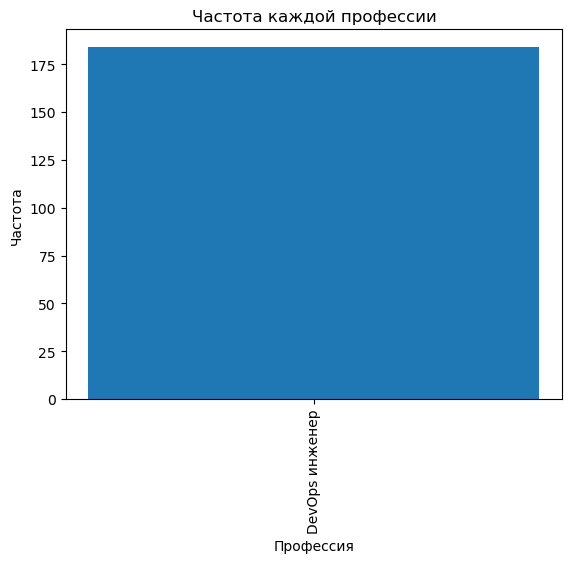

In [574]:
plt.bar(profession_counts.index, profession_counts.values)
plt.xlabel('Профессия')
plt.ylabel('Частота')
plt.title('Частота каждой профессии')
plt.xticks(rotation=90)  # Поворот значений по оси X
plt.show()

## Использование реальных данных

In [575]:
# Загрузка модели
model = CatBoostClassifier()
model.load_model('catboost_model.bin')

In [576]:
# Загрузка данных
df = pd.DataFrame(res)
df = df.rename(columns={0: 'Tag'})
df['Tag'] = df['Tag'].astype(str)

In [577]:
text_array = df['Tag'].values.astype(str)
arr_obj = text_array.astype(object)

In [578]:
# Преобразование текстовых данных в числовые с помощью BoW (мешок слов)
XX_real_tokenized = [text.split() for text in arr_obj]

In [579]:
model2_ft = FastText(
    sentences=XX_real_tokenized, 
    vector_size=100, 
    window=5, 
    min_count=5
)

In [580]:
predictions = model.predict(X_train_bow)

In [581]:
result3 = pd.DataFrame(predictions)

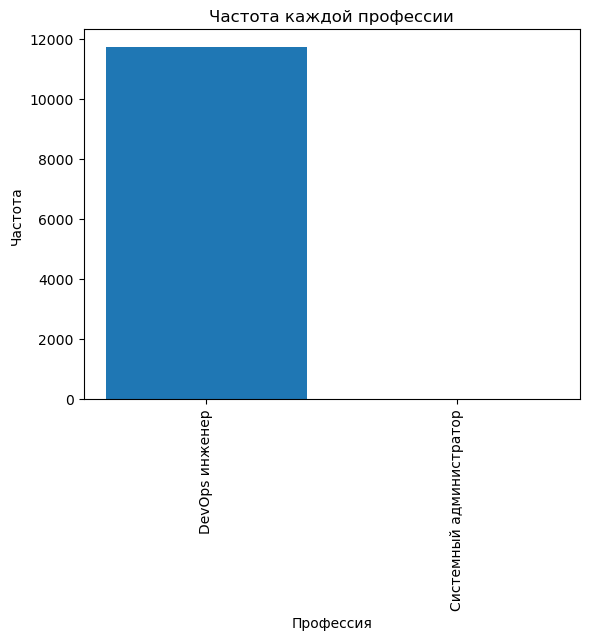

In [582]:
y_pred_df = pd.DataFrame({'Profession': predictions.flatten()})
profession_counts = y_pred_df['Profession'].value_counts().head(20)
profession_counts = profession_counts[profession_counts.index != 'nan']
plt.bar(profession_counts.index, profession_counts.values)
plt.xlabel('Профессия')
plt.ylabel('Частота')
plt.title('Частота каждой профессии')
plt.xticks(rotation=90)  # Поворот значений по оси X
plt.show()

## Обучение модели по названием видео

In [583]:
mean_video = filtered_dataset['total_seconds'].mean()
filtered_dataset['weight_to_model'] = (filtered_dataset['total_seconds'] * filtered_dataset['Weight'] / mean_video)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_2116\1365410757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset['weight_to_model'] = (filtered_dataset['total_seconds'] * filtered_dataset['Weight'] / mean_video)


In [584]:
new_model = filtered_dataset[['weight_to_model', 'ChannelTitle', 'Category', 'Title']]

In [585]:
new_model_new = pd.read_excel('new_model_new_xxx.xlsx', sheet_name='model2')

## Предобработка данных

In [630]:
new_model_new['Title'] = new_model_new['Title'].str.lower()
new_model_new['Title'] = new_model_new['Title'].str.replace('\d+', '', regex=True)
new_model_new['Title'] = new_model_new['Title'].str.replace('[^а-яА-Яa-zA-Z\s]', '', regex=True)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_2116\3543377930.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_model_new['Title'] = new_model_new['Title'].str.lower()
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_2116\3543377930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_model_new['Title'] = new_model_new['Title'].str.replace('\d+', '', regex=True)
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_2116\3543377930.py:3: SettingWithCopyWarning: 
A value is trying to be set on a 

In [632]:
new_model_new.groupby(by='Profession').count().sort_values(by='Title')

,Title
Profession,
Android-разработчик,49
Backend-разработчик,50
DevOps инженер,50
Frontend-разработчик,50
ML Разработчик,50
Swift-разработчик,50
UI/UX дизайнер,50
Бизнес-аналитик/Системный аналитик/Аналитик данных,50
Разработчик ПО,50


In [633]:
new_model_new['Title'] = new_model_new['Title'].astype(str)
new_model_new['Profession'] = new_model_new['Profession'].astype(str)
new_model_new['weight_to_model'] = new_model_new['weight_to_model'].astype(float)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_2116\1427112173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_model_new['Title'] = new_model_new['Title'].astype(str)
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_2116\1427112173.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_model_new['Profession'] = new_model_new['Profession'].astype(str)


KeyError: 'weight_to_model'

In [634]:
new_model_new.dtypes

Title         object
Profession    object
dtype: object

In [637]:
new_model_new = new_model_new[['Title', 'Profession']] ##Норм

In [638]:
new_model_new

,Title,Profession
0,смарт тв не видит интернет как подключить тел...,Android-разработчик
1,что учить новичку в android java vs kotlin моб...,Android-разработчик
2,как стать androidразработчиком в году,Android-разработчик
3,уроки android studio с нуля разработка андр...,Android-разработчик
4,уроки android studio с нуля интерфеис прогр...,Android-разработчик
5,уроки android studio с нуля написание кода ...,Android-разработчик
6,уроки android studio с нуля всплывающие соо...,Android-разработчик
7,уроки android studio с нуля переход между с...,Android-разработчик
8,чем занимается android разработчик требования ...,Android-разработчик
9,java,Android-разработчик


In [639]:
# Создание признаков и целевой переменной
x = new_model_new['Profession']
y = new_model_new['Title']

In [640]:
# Разделение данных на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=21)

In [641]:
# Предварительная обработка текста и разделение на токены
x_train_token = [gensim.utils.simple_preprocess(i) for i in x_train]
x_test_token = [gensim.utils.simple_preprocess(i) for i in x_test]

In [642]:
fasttext_model = gensim.models.FastText(
    sentences=x_train_token, 
    vector_size=100, 
    min_count=1, 
    window=5, 
    sg=0, 
    hs=1
)

In [643]:
def sentence_vector(sentence, model):
    if len(sentence)!= 0:
        return np.mean([model.wv[word] for word in sentence], axis=0)
    else:
        return np.zeros(model.vector_size)               # возвращает вектор нулей той же размерности, что и другие векторы

In [644]:
x_train_vec = [sentence_vector(sentence, fasttext_model) for sentence in x_train_token]
x_test_vec = [sentence_vector(sentence, fasttext_model) for sentence in x_test_token]

In [683]:
model2 = CatBoostClassifier(
    iterations=500,
    random_state=11,
    learning_rate=0.1,
)
model2.fit(
    x_train_vec, yy_train,
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [684]:
print('Обучена ли модель: ' + str(model2.is_fitted()))

Обучена ли модель: True


In [715]:
# Классификация текстов
y_pred = model2.predict(x_train_vec)

# Оценка качества модели
# accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.0


In [690]:
model2.save_model('catboost_model2.bin')

In [691]:
y_pred_df = pd.DataFrame({'Profession': y_pred.flatten()})
profession_counts = y_pred_df['Profession'].value_counts()
# profession_counts = profession_counts[profession_counts.index != 'nan']

In [692]:
profession_counts

Profession
DevOps инженер                                        48
UI/UX дизайнер                                        47
Backend-разработчик                                   47
Разработчик игр                                       47
Бизнес-аналитик/Системный аналитик/Аналитик данных    46
Frontend-разработчик                                  45
Разработчик ПО                                        45
Специалист по информационной безопасности             44
Swift-разработчик                                     44
Android-разработчик                                   43
ML Разработчик                                        42
Системный администратор                               41
Name: count, dtype: int64

Внизу угаданные данные. Мы можем это видеть внизу.

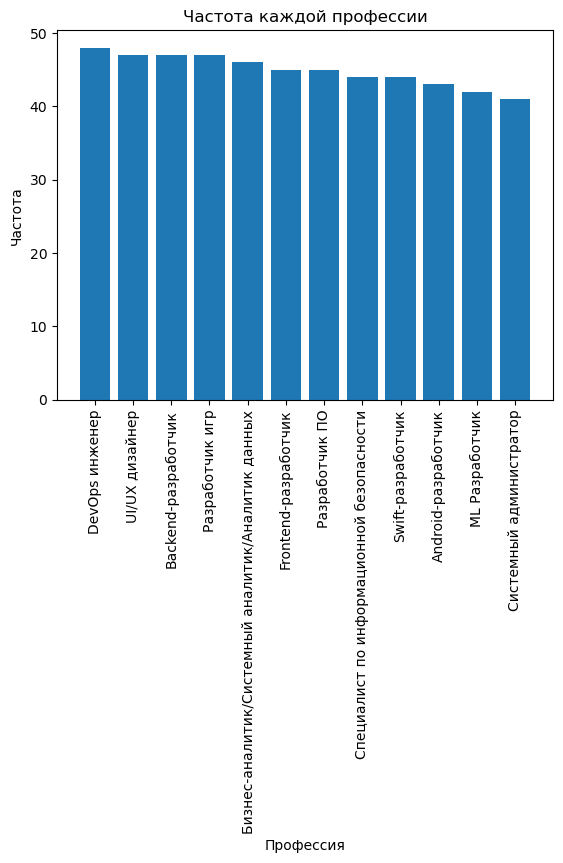

In [693]:
plt.bar(profession_counts.index, profession_counts.values)
plt.xlabel('Профессия')
plt.ylabel('Частота')
plt.title('Частота каждой профессии')
plt.xticks(rotation=90)  # Поворот значений по оси X
plt.show()

## Реальные данные

In [716]:
model2 = CatBoostClassifier()
model2.load_model('catboost_model2.bin')

In [717]:
x_real = filtered_dataset['Title']

In [718]:
x_real_token = [gensim.utils.simple_preprocess(i) for i in x_real]

In [719]:
fasttext_model_real = gensim.models.FastText(
    sentences=x_real_token, 
    vector_size=100, 
    min_count=1, 
    window=5, 
    sg=0, 
    hs=1
)

In [720]:
x_real_vec = [sentence_vector(sentence, fasttext_model) for sentence in x_real_token]

In [721]:
predictions = model2.predict(x_real_vec)

In [724]:
y_prediction_df

,Profession
0,Бизнес-аналитик/Системный аналитик/Аналитик да...
1,Frontend-разработчик
2,DevOps инженер
3,DevOps инженер
4,Frontend-разработчик
5,DevOps инженер
6,Специалист по информационной безопасности
7,Frontend-разработчик
8,Системный администратор
9,Специалист по информационной безопасности


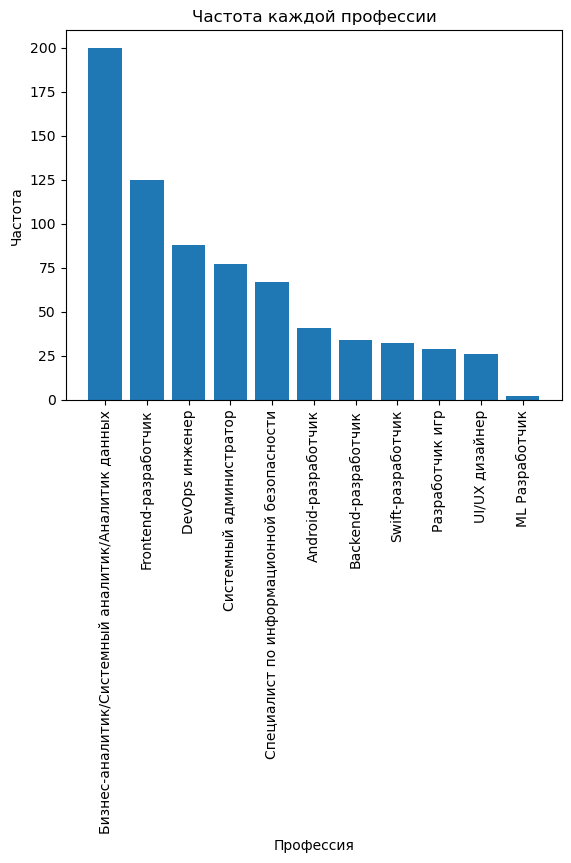

In [722]:
y_prediction_df = pd.DataFrame({'Profession': predictions.flatten()})
profession_counts = y_prediction_df['Profession'].value_counts()
profession_counts = profession_counts[profession_counts.index != 'nan']
plt.bar(profession_counts.index, profession_counts.values)
plt.xlabel('Профессия')
plt.ylabel('Частота')
plt.title('Частота каждой профессии')
plt.xticks(rotation=90)  # Поворот значений по оси X
plt.show()